Grupo:
1.   Francisko Alexandre
2.   Otávio
3.   Ryan

### Bibliotecas

In [1]:
# Importação das bibliotecas

import numpy as np                             # Usado p/ operações numéricas
import matplotlib.pyplot as plt                # Usado p/ criar visualizações

import torch                                   # Biblioteca principal do Pytorch (Framework de Deep Learning)
import torch.nn as nn                          # Módulo de redes neurais do Pytorch
from torch import optim                        # Otimizadores do Pytorch
import torch.nn.functional as F                # Módulo de funções funcionais do PyTorch, que contém funções de ativação, perda, etc
from torchvision import datasets               # Módulo datasets da biblioteca TorchVision
import torchvision.transforms as transforms    # Usado para aplicar transformações nas imagens

print(f"PyTorch version: {torch.__version__}") # Imprime a versão do PyTorch que está sendo utilizada

PyTorch version: 2.8.0+cu126


### Funções auxiliares para a execução

In [2]:
# Define a função imshow que aceita um tensor de imagem, um objeto ax (para o gráfico), um título e um flag normalize (para aplicar normalização)
def imshow(image, ax=None, title=None, normalize=True):
    """Imshow for Tensor."""
    # Se nenhum objeto ax for fornecido, é criada uma nova figura e eixos para o gráfico
    if ax is None:
        fig, ax = plt.subplots()

    # Converte o tensor PyTorch para um array NumPy e muda a ordem das dimensões de (canais, altura, largura) para (altura, largura, canais), que é o formato esperado pelo Matplotlib
    # CIFAR-10 images have 3 channels, so adjust transpose
    image = image.numpy().transpose((1, 2, 0))

    # Se normalize for True, aplica a denormalização à imagem. Isso é necessário porque as imagens do CIFAR-10 foram normalizadas anteriormente com média 0.5 e desvio padrão 0.5 para cada canal
    if normalize:
        # Normalization for 3 channels
        mean = np.array([0.5, 0.5, 0.5])
        std = np.array([0.5, 0.5, 0.5])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    # Removem as bordas e rótulos dos eixos para uma visualização mais limpa da imagem
    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    # Retorna o objeto ax para que você possa fazer mais personalizações no gráfico, se necessário
    return ax

### Base de dados

100%|██████████| 170M/170M [00:01<00:00, 102MB/s]


Dataset CIFAR-10 carregado com sucesso!
Número de imagens de treinamento: 50000
Número de imagens de teste: 10000

Mapeamento de classes para índices:
{'airplane': 0, 'automobile': 1, 'bird': 2, 'cat': 3, 'deer': 4, 'dog': 5, 'frog': 6, 'horse': 7, 'ship': 8, 'truck': 9}



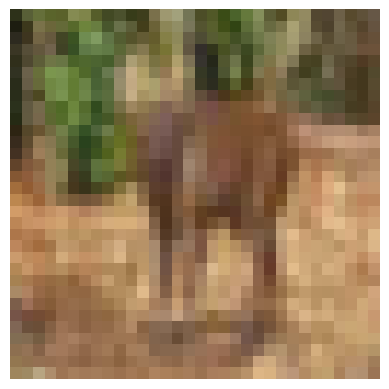

In [3]:
# Carregando o dataset CIFAR-10

# Transformações para o CIFAR-10 (imagens coloridas 32x32)
transform_cifar = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # Normalização para 3 canais de cor
])

# Download e carregamento dos dados de treinamento do CIFAR-10: Este dataset contém 60.000 imagens coloridas de 32x32 pixels em 10 classes
# (avião, carro, pássaro, gato, cervo, cachorro, sapo, cavalo, navio, caminhão)
trainset_cifar = datasets.CIFAR10('.', download=True, train=True, transform=transform_cifar)
trainloader_cifar = torch.utils.data.DataLoader(trainset_cifar, batch_size=64, shuffle=True)

# Download e carregamento dos dados de teste do CIFAR-10
testset_cifar = datasets.CIFAR10('.', download=True, train=False, transform=transform_cifar)
testloader_cifar = torch.utils.data.DataLoader(testset_cifar, batch_size=64, shuffle=True)

print("Dataset CIFAR-10 carregado com sucesso!")
print(f"Número de imagens de treinamento: {len(trainset_cifar)}")
print(f"Número de imagens de teste: {len(testset_cifar)}\n")

# --- Acessar o mapeamento de classes ---
print("Mapeamento de classes para índices:")
print(trainset_cifar.class_to_idx)
print()

# Visualizando uma imagem de exemplo do CIFAR-10
image, label = next(iter(trainloader_cifar))
imshow(image[0,:]);



### Variações da Arquitetura da Rede Neural

In [4]:
# Arquitetura original
class ClassifierCIFAR10_V1(nn.Module): # Defini uma classe chamada ClassifierCIFAR10_V1 que herda de nn.Module, a classe base para todos
                                       # os módulos de rede neural no PyTorch.

    # Construtor da classe. É onde é definida as camadas da rede neural.
    def __init__(self):
        super().__init__()                     # Chama o construtor da classe pai (nn.Module)
        self.fc1 = nn.Linear(32 * 32 * 3, 256) # Definição da primeira camada (altura * largura * canais de cor da imagem CIFAR-10) e 256 neurônios na saída
        self.fc2 = nn.Linear(256, 128)         # Definição da segunda camada, recebendo 256 entradas e tendo 128 neurônios na saída
        self.fc3 = nn.Linear(128, 64)          # Definição da terceira camada, recebendo 128 entradas e tendo 64 neurônios na saída
        self.fc4 = nn.Linear(64, 10)           # Definição da quarta camada, recebendo 64 entradas e tendo 10 neurônios

    def forward(self, x):                      # Define o fluxo de dados através da rede neural. x é o tensor de entrada
                                               # (neste caso, uma imagem ou um lote de imagens).
        x = x.view(x.shape[0], -1)             # Redimensiona o tensor de entrada x
        x = F.relu(self.fc1(x))                # Passa o vetor achatado pela primeira camada fc1 e aplica a função de ativação ReLU (F.relu)
        x = F.relu(self.fc2(x))                # Passa a saída da camada anterior pela segunda camada fc2 e aplica ReLU
        x = F.relu(self.fc3(x))                # Passa a saída da camada anterior pela terceira camada fc3 e aplica ReLU
        x = self.fc4(x)                        # Passa a saída da camada anterior pela última camada fc4

        # Retorna a saída da rede neural
        return x

# Arquitetura com menor numero de camadas e neurônios - Essa segunda arquitetura segue a mesma lógica que a anterior, mas possui uma camadas extras
# self.fc5 e um número maior de neurônios nas camadas anteriores. Isso torna a arquitetura mais profunda e com maior capacidade
class ClassifierCIFAR10_V2(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(32 * 32 * 3, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


### Função de Treinamento e Avaliação

In [5]:
# Função que define o fluxo de treinamento e avaliação

# Cria um dicionário para armazenar as métricas (perda e acurácia) de treinamento e teste ao longo das épocas
def train_and_evaluate(network, trainloader, testloader, criterion, optimizer, epochs, device):
    history = {'train_loss': [], 'train_accuracy': [], 'test_loss': [], 'test_accuracy': []}

    # Itera sobre o número de épocas especificado.
    for epoch in range(epochs):
        print(f'Época {epoch+1}/{epochs}')

        # Treinamento
        network.train() # Coloca a rede no modo de treinamento

        # Inicializa as variáveis para acumular a perda e a acurácia durante o treinamento
        running_loss = 0.
        running_accuracy = 0.

        # Itera sobre os lotes de dados do trainloader
        for i, data in enumerate(trainloader):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = network(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            ps = F.softmax(outputs, dim=1)
            top_p, top_class = ps.topk(k = 1, dim = 1)
            equals = top_class == labels.view(*top_class.shape)
            accuracy = torch.mean(equals.type(torch.float))
            running_accuracy += accuracy

        epoch_train_loss = running_loss / len(trainloader)
        epoch_train_accuracy = running_accuracy / len(trainloader)
        history['train_loss'].append(epoch_train_loss)
        history['train_accuracy'].append(epoch_train_accuracy)
        print(f'  Treinamento - Perda: {epoch_train_loss:.5f} - Acurácia: {epoch_train_accuracy:.5f}')

        # Avaliação
        network.eval()
        running_loss = 0.
        running_accuracy = 0.
        with torch.no_grad():
            for i, data in enumerate(testloader):
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = network(inputs)
                loss = criterion(outputs, labels)

                running_loss += loss.item()

                ps = F.softmax(outputs, dim=1)
                top_p, top_class = ps.topk(k = 1, dim = 1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy = torch.mean(equals.type(torch.float))
                running_accuracy += accuracy

        epoch_test_loss = running_loss / len(testloader)
        epoch_test_accuracy = running_accuracy / len(testloader)
        history['test_loss'].append(epoch_test_loss)
        history['test_accuracy'].append(epoch_test_accuracy)
        print(f'  Teste       - Perda: {epoch_test_loss:.5f} - Acurácia: {epoch_test_accuracy:.5f}')
        print('-' * 50)

    return history

### Comparação das Arquiteturas V1 e V2

Utilizando device: cpu
Treinando e avaliando: Arquitetura V1
Época 1/30
  Treinamento - Perda: 2.20221 - Acurácia: 0.19925
  Teste       - Perda: 2.04471 - Acurácia: 0.27279
--------------------------------------------------
Época 2/30
  Treinamento - Perda: 1.93330 - Acurácia: 0.30942
  Teste       - Perda: 1.83352 - Acurácia: 0.34912
--------------------------------------------------
Época 3/30
  Treinamento - Perda: 1.76887 - Acurácia: 0.37076
  Teste       - Perda: 1.70426 - Acurácia: 0.38983
--------------------------------------------------
Época 4/30
  Treinamento - Perda: 1.66270 - Acurácia: 0.40533
  Teste       - Perda: 1.61895 - Acurácia: 0.42884
--------------------------------------------------
Época 5/30
  Treinamento - Perda: 1.59127 - Acurácia: 0.43372
  Teste       - Perda: 1.55925 - Acurácia: 0.44835
--------------------------------------------------
Época 6/30
  Treinamento - Perda: 1.52650 - Acurácia: 0.45726
  Teste       - Perda: 1.51167 - Acurácia: 0.46736
------

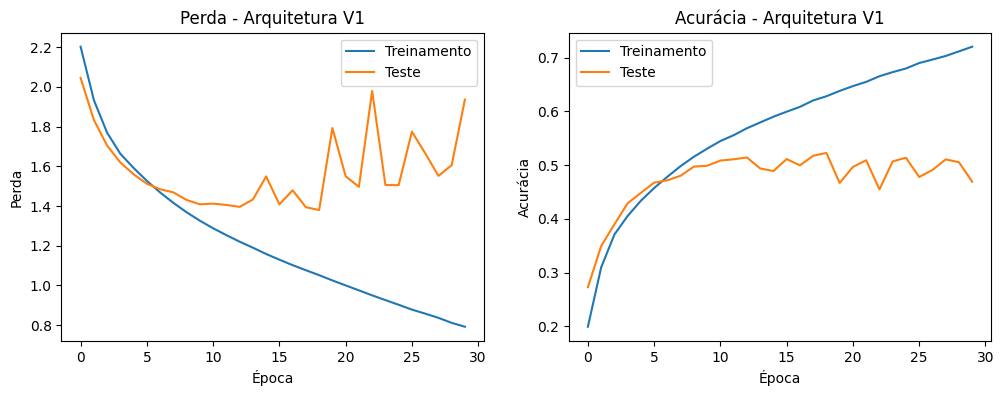


--- Arquitetura V2 ---
Acurácia Final de Treinamento: 0.67062
Acurácia Final de Teste      : 0.51463

Perda Final de Treinamento   : 0.94513
Perda Final de Teste         : 1.43415


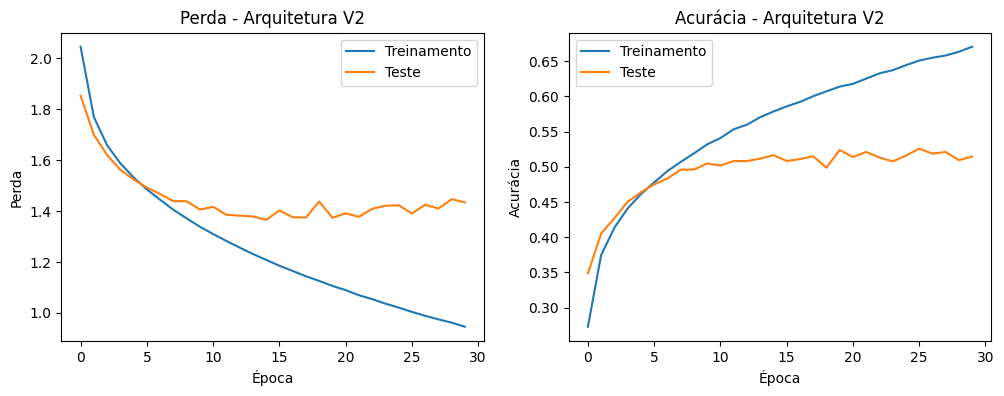

In [8]:
# verificando disponibilidade da gpu e enviando a rede para o device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f"Utilizando device: {device}")

# Definindo as arquiteturas a serem comparadas
architectures = {
    'Arquitetura V1': ClassifierCIFAR10_V1(),
    'Arquitetura V2': ClassifierCIFAR10_V2()
    # Adicione outras arquiteturas aqui
}

# Define o número de épocas para o treinamento e inicializa um dicionário vazio chamado results para armazenar o histórico
# de treinamento e avaliação de cada arquitetura.
epochs = 30 # Você pode ajustar o número de épocas para a comparação
results = {}

for name, network in architectures.items():
    print(f'Treinando e avaliando: {name}')
    network.to(device)

    # Definindo parâmetros importantes do treinamento para cada arquitetura
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(network.parameters(), lr=0.01)

    # Executando o treinamento e teste
    history = train_and_evaluate(network, trainloader_cifar, testloader_cifar, criterion, optimizer, epochs, device)
    results[name] = history
    print('\n' + '='*50 + '\n')

# Apresentando os resultados comparativos
print("Resultados da Comparação de Arquiteturas:")
for name, history in results.items():
    print(f'\n--- {name} ---')
    print(f'Acurácia Final de Treinamento: {history["train_accuracy"][-1]:.5f}')
    print(f'Acurácia Final de Teste      : {history["test_accuracy"][-1]:.5f}')
    print()
    print(f'Perda Final de Treinamento   : {history["train_loss"][-1]:.5f}')
    print(f'Perda Final de Teste         : {history["test_loss"][-1]:.5f}')

    # Opcional: Plotar gráficos de perda e acurácia ao longo das épocas
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Treinamento')
    plt.plot(history['test_loss'], label='Teste')
    plt.title(f'Perda - {name}')
    plt.xlabel('Época')
    plt.ylabel('Perda')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history['train_accuracy'], label='Treinamento')
    plt.plot(history['test_accuracy'], label='Teste')
    plt.title(f'Acurácia - {name}')
    plt.xlabel('Época')
    plt.ylabel('Acurácia')
    plt.legend()
    plt.show()

Label original: 8
Shape da imagem para previsão: torch.Size([1, 3, 32, 32])
A classe predita é: 8

 Classe: ship


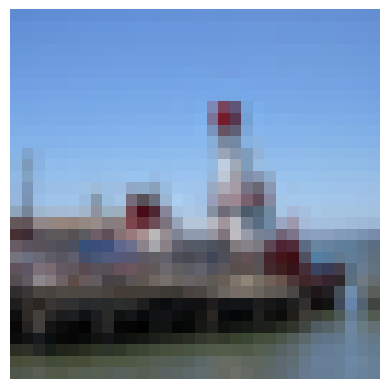

In [7]:
# Percorrendo as imagens do loader de teste e pegando uma imagem unica
# Ajuste o índice [12] se necessário para visualizar outras imagens
images_test, labels_test = next(iter(testloader_cifar))
imagem_exemplo = images_test[12]
label_exemplo = labels_test[12]

# Visualizando a imagem
imshow(imagem_exemplo, normalize=True);

print(f"Label original: {label_exemplo}")

# Formatando imagem para o shape requerido pelo pytorch (adiciona dimensão de batch)
imagem_exemplo = imagem_exemplo.unsqueeze(0)
print(f"Shape da imagem para previsão: {imagem_exemplo.shape}")

# Colocando a rede no modo eval e passando para o device
network.eval()
imagem_exemplo = imagem_exemplo.to(device)

# Realizando previsão
with torch.no_grad():
    previsao = network(imagem_exemplo)

# Aplicando softmax nos scores para gerar as probabilidades
prob = F.softmax(previsao, dim=1)

# Obtendo a classe predita
top_p, top_class = prob.topk(k = 1, dim = 1)
resultado = top_class.item()

print(f'A classe predita é: {resultado}')

# Mapeando o índice da classe para o nome da classe (para CIFAR-10)
classes_cifar10 = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
print('\n Classe: ' + classes_cifar10[resultado])

# Métricas e gráficos de execuções anteriores

In [10]:
def plot_losses_and_accuracies(losses, accuracies, subtitle=""):
    # Eixo X = número de épocas
    epochs = range(1, len(losses) + 1)

    # Criar figura e eixos
    fig, ax1 = plt.subplots(figsize=(10,5))

    # Plot das perdas
    ax1.plot(epochs, losses, color='red', label='Loss')
    ax1.set_xlabel('Épocas')
    ax1.set_ylabel('Loss', color='red')
    ax1.tick_params(axis='y', labelcolor='red')

    # Segundo eixo Y para acurácia
    ax2 = ax1.twinx()
    ax2.plot(epochs, accuracies, color='blue', label='Accuracy')
    ax2.set_ylabel('Accuracy', color='blue')
    ax2.tick_params(axis='y', labelcolor='blue')

    # Título e grid
    plt.title('Evolução do Loss e da Accuracy' + ("" if len(subtitle) == 0 else f": {subtitle}"))
    ax1.grid(True)

    plt.show()

def plot_single_line(points, color="red", x_label="Valores", title="Evolução do Loss"):
    # Eixo X = número de épocas
    x_axis = range(1, len(points) + 1)

    # Criar figura e eixos
    fig, ax1 = plt.subplots(figsize=(10,5))

    # Plot das perdas
    ax1.plot(x_axis, points, color=color, label='Loss')
    ax1.set_xlabel('Épocas')
    ax1.set_ylabel('Loss', color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    # Título e grid
    plt.title(title)
    ax1.grid(True)

    plt.show()


def plot_all_graphs(losses_training, losses_testing, accuracies_training, accuracies_testing):
    plot_losses_and_accuracies(losses_training, accuracies_training, "Treinamento")
    plot_losses_and_accuracies(losses_testing, accuracies_testing, "Testes")

    plot_single_line(losses_training, color="red", x_label="Épocas", title="Evolução do Loss: Treino")
    plot_single_line(losses_testing, color="red", x_label="Épocas", title="Evolução do Loss: Testes")

    plot_single_line(accuracies_training, color="blue", x_label="Épocas", title="Evolução da Accuracy: Treino")
    plot_single_line(accuracies_testing, color="blue", x_label="Épocas", title="Evolução da Accuracy: Testes")

# Arquitetura 1 (original): Camadas com 3072, 256, 128, 64 e 10 neurônios (30 épocas)

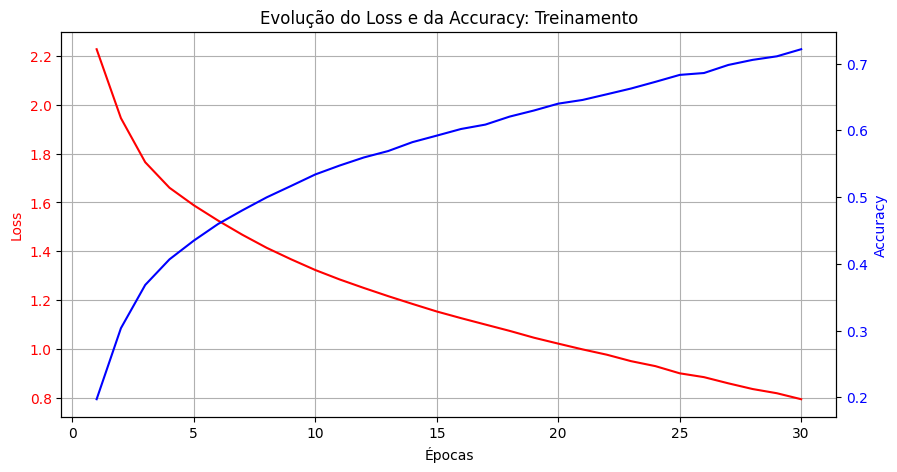

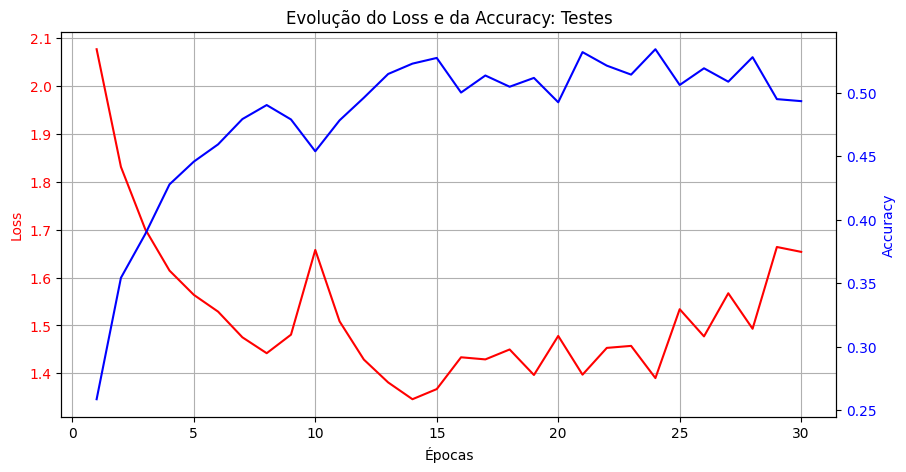

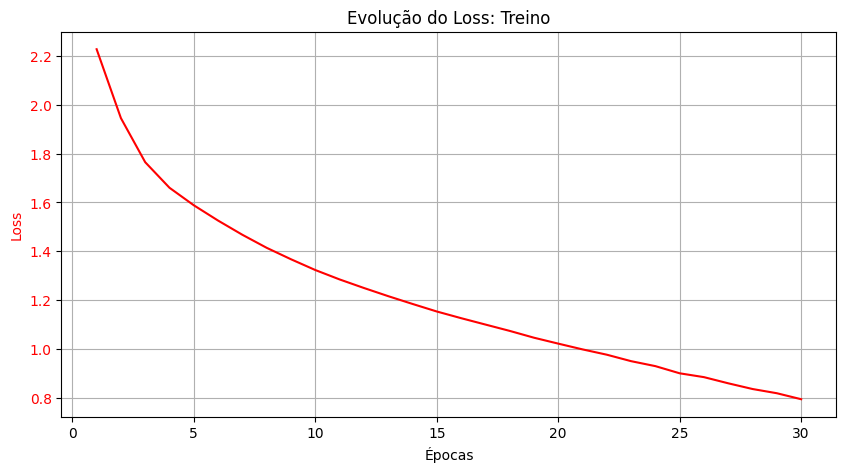

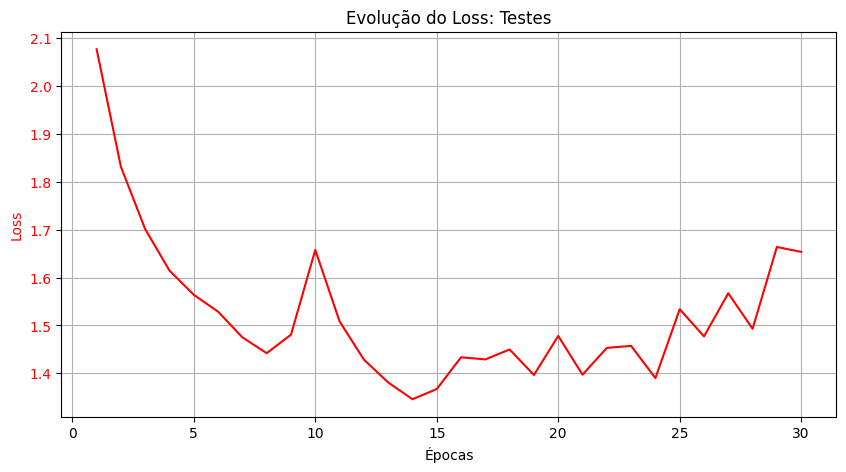

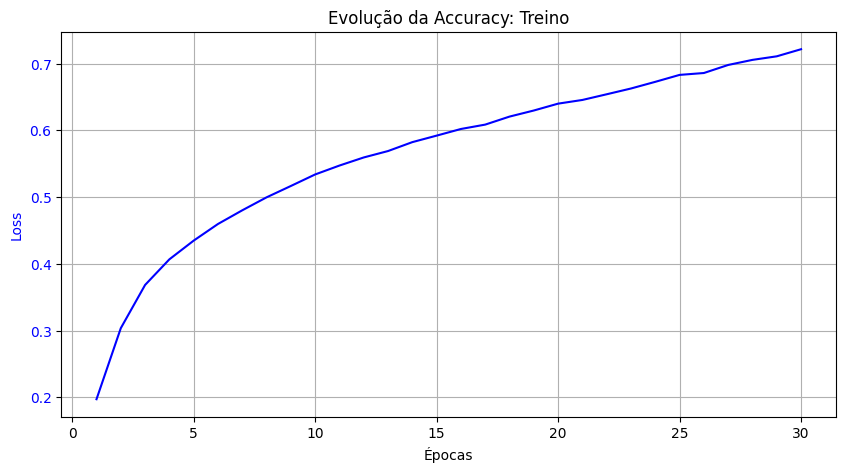

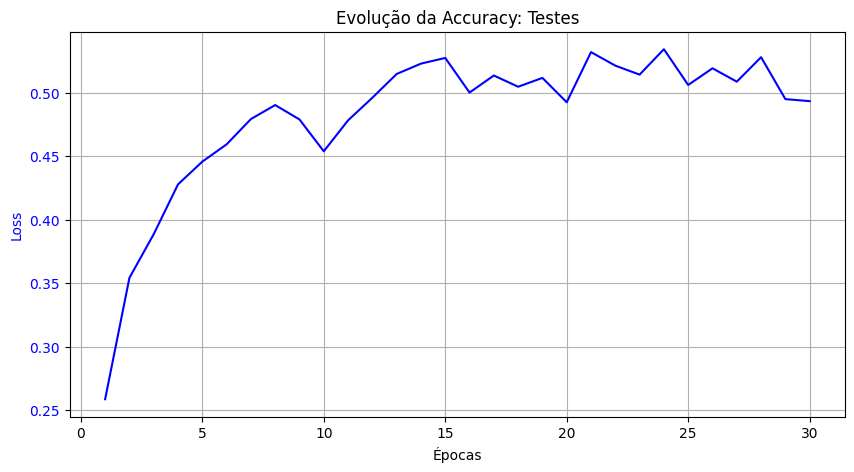

In [11]:
losses_training = [2.22832, 1.94575, 1.76508, 1.66025, 1.58855, 1.52575, 1.46755, 1.41413, 1.36723, 1.32311, 1.28456, 1.24951, 1.21601, 1.18412, 1.15313, 1.12577, 1.09964, 1.07362, 1.04564, 1.02136, 0.99772, 0.97593, 0.94943, 0.92906, 0.89967, 0.88391, 0.85863, 0.83524, 0.81795, 0.79342]
losses_testing = [2.07734, 1.83147, 1.70122, 1.6146, 1.56392, 1.52878, 1.47513, 1.44191, 1.48063, 1.65775, 1.5085, 1.4286, 1.38083, 1.34573, 1.36693, 1.4334, 1.42896, 1.44972, 1.39637, 1.47804, 1.39703, 1.45303, 1.45721, 1.38989, 1.53389, 1.47708, 1.56722, 1.49301, 1.66394, 1.65374]
accuracies_training = [0.19705, 0.30349, 0.36827, 0.40667, 0.4347, 0.45962, 0.48012, 0.49954, 0.51656, 0.53383, 0.54717, 0.5593, 0.56891, 0.58226, 0.59201, 0.60196, 0.60852, 0.62052, 0.62964, 0.63993, 0.64546, 0.65397, 0.66262, 0.67261, 0.683, 0.68582, 0.69789, 0.7055, 0.71084, 0.72147]
accuracies_testing = [0.25856, 0.3542, 0.38863, 0.42785, 0.44576, 0.45939, 0.4793, 0.49035, 0.479, 0.45392, 0.4783, 0.49612, 0.51483, 0.52299, 0.52747, 0.5002, 0.51363, 0.50478, 0.51174, 0.49254, 0.53205, 0.5214, 0.51433, 0.53434, 0.50617, 0.51931, 0.50876, 0.52807, 0.49502, 0.49343]

plot_all_graphs(losses_training, losses_testing, accuracies_training, accuracies_testing)

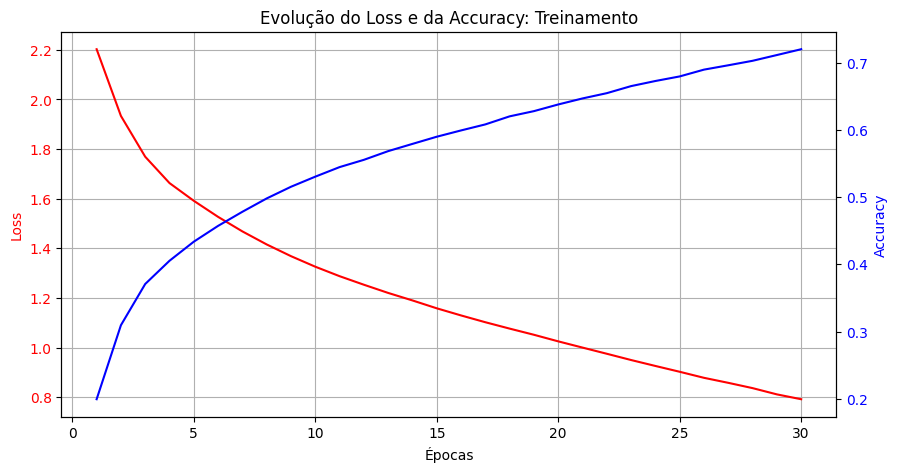

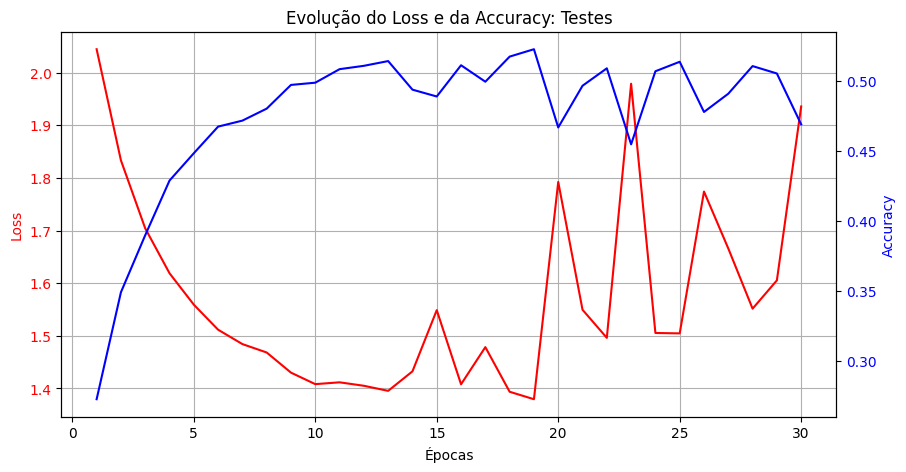

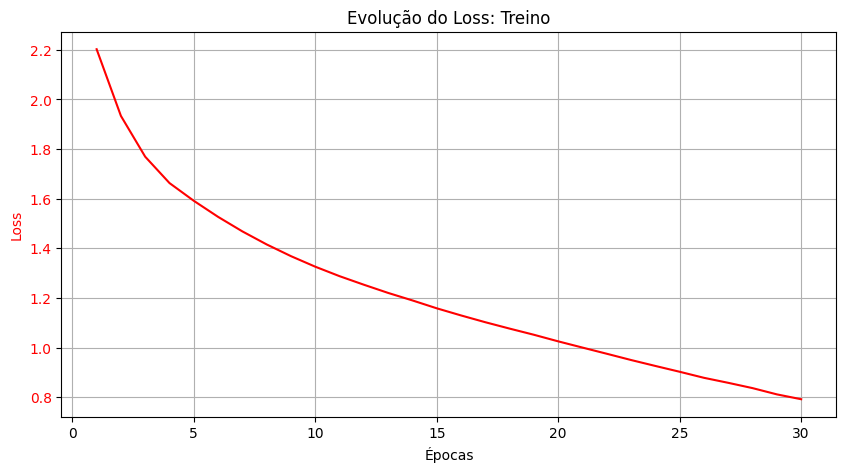

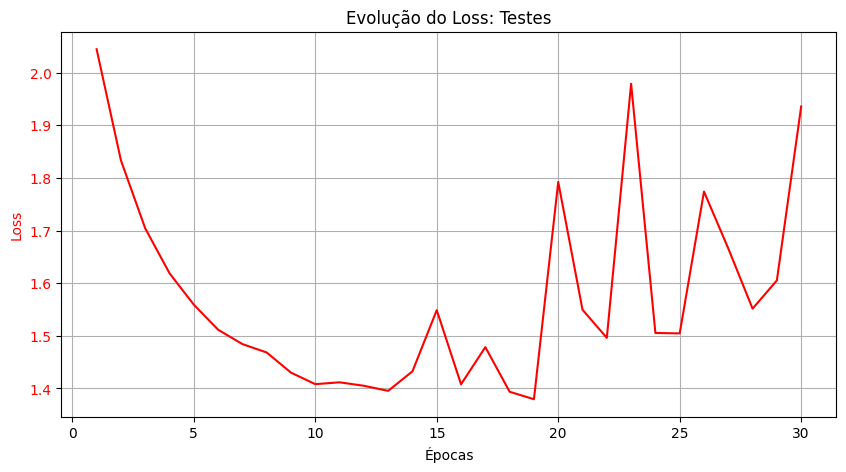

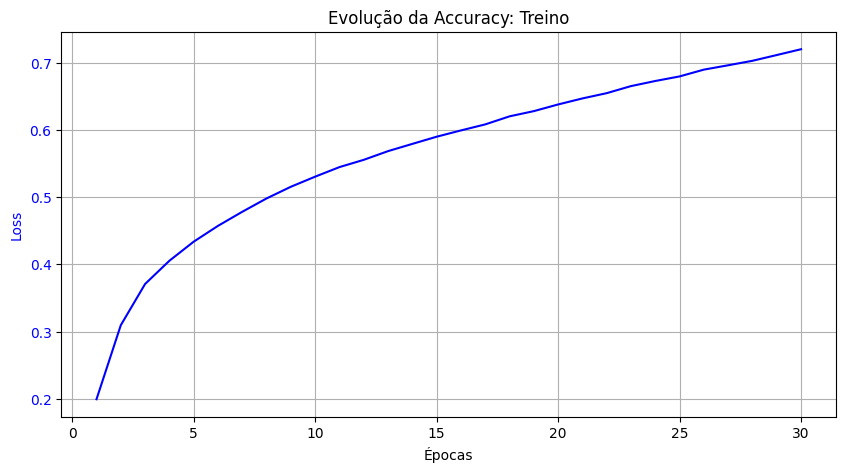

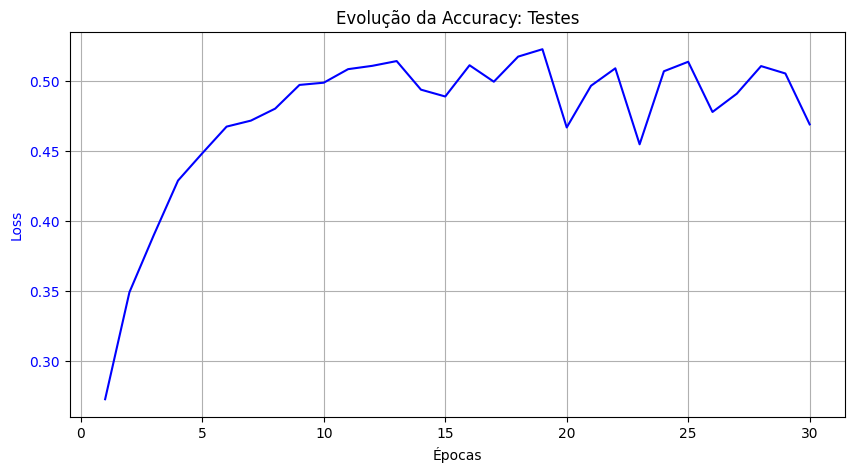

In [20]:
plot_all_graphs(results['Arquitetura V1']['train_loss'], results['Arquitetura V1']['test_loss'], results['Arquitetura V1']['train_accuracy'], results['Arquitetura V1']['test_accuracy'])

# Arquitetura 2 (menos camadas): Camadas com 3072, 128, 64 e 10 neurônios (30 épocas)

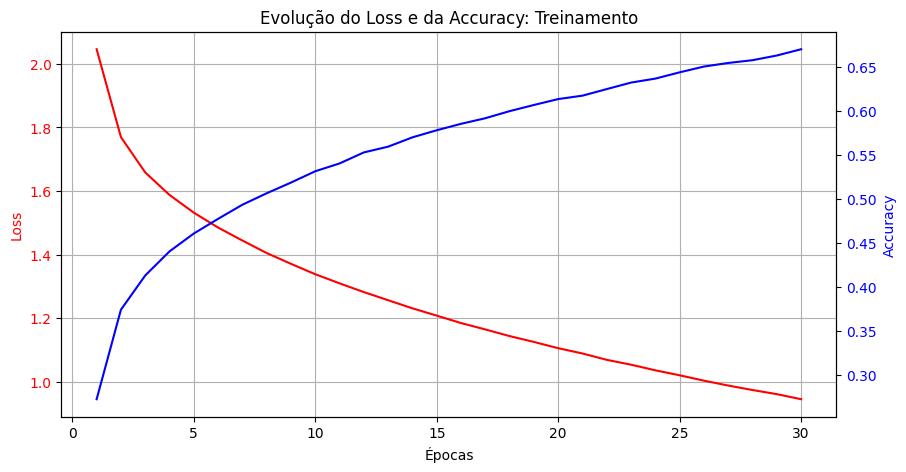

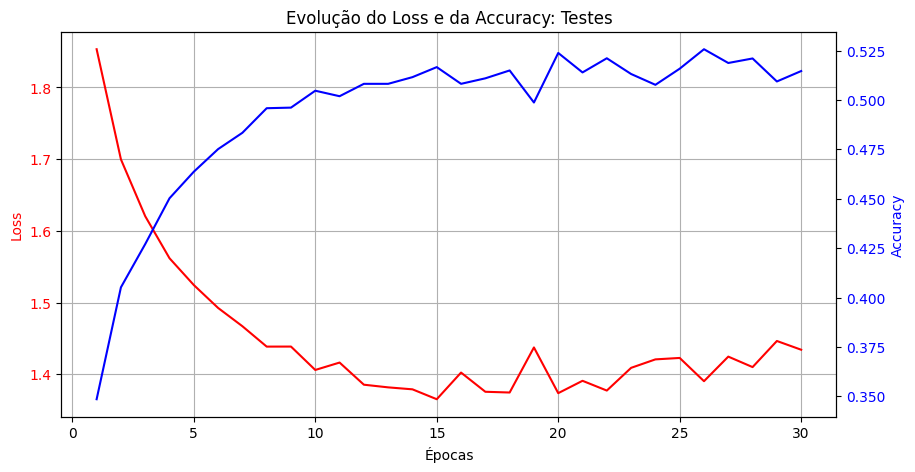

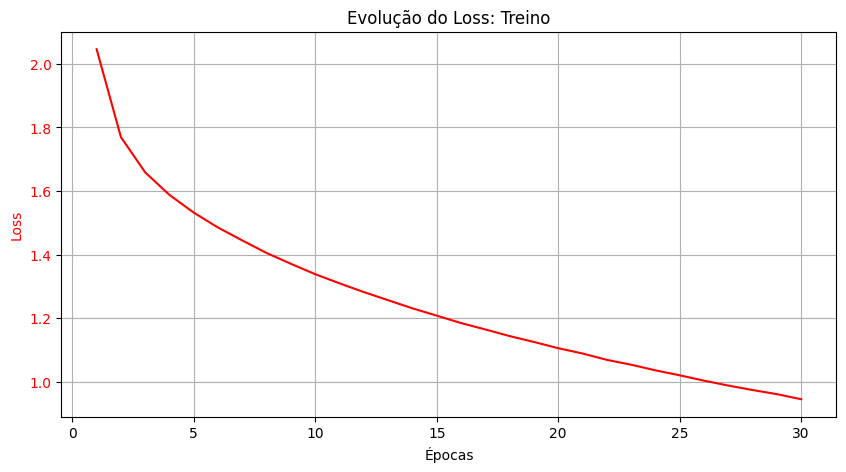

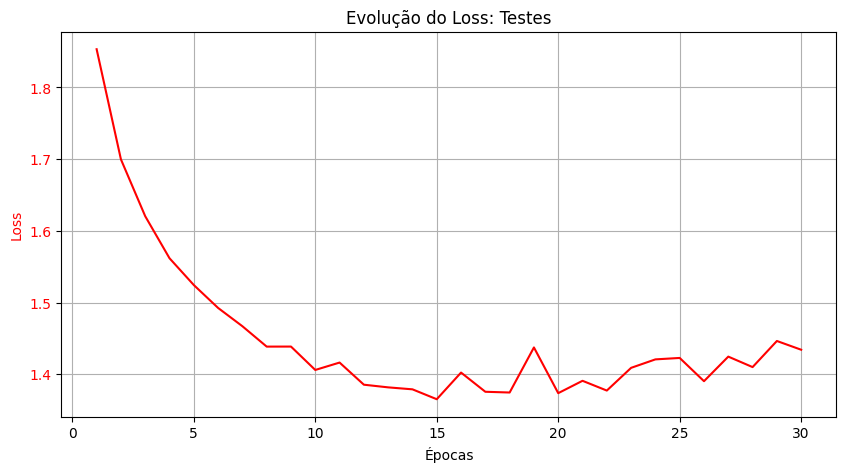

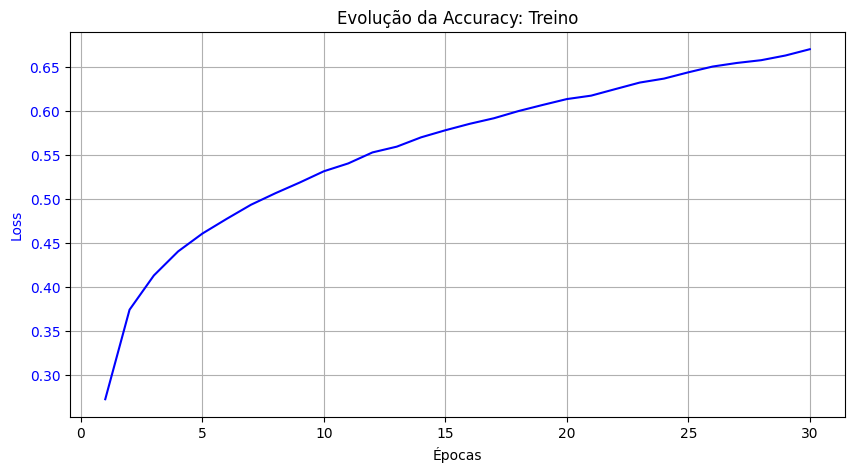

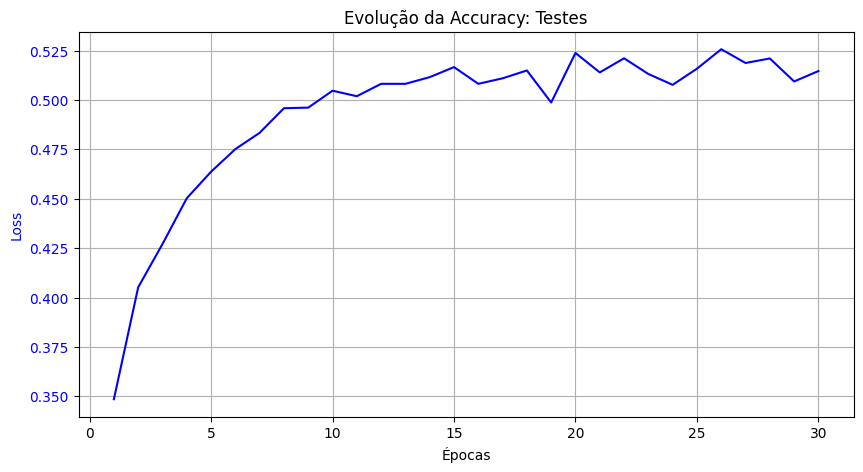

In [19]:
plot_all_graphs(results['Arquitetura V2']['train_loss'], results['Arquitetura V2']['test_loss'], results['Arquitetura V2']['train_accuracy'], results['Arquitetura V2']['test_accuracy'])

# Arquitetura 3 (menos neurônios): Camadas com 3072, 256, 64, 32, 10 neurônios (30 épocas)

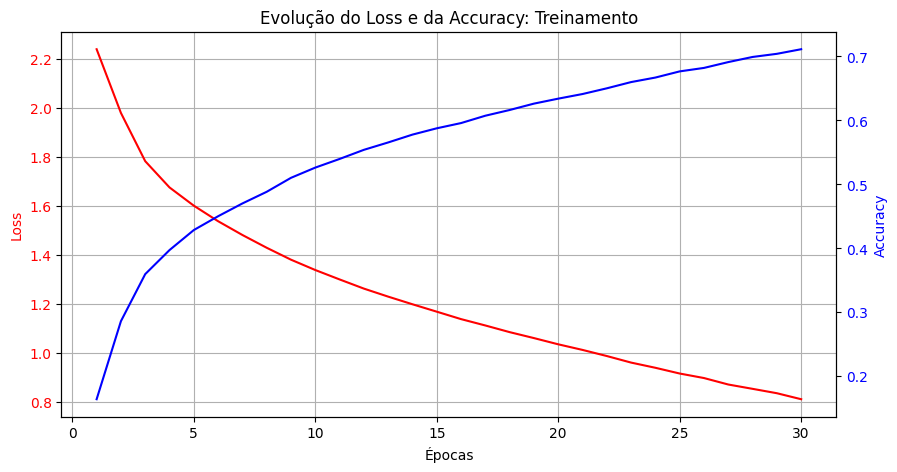

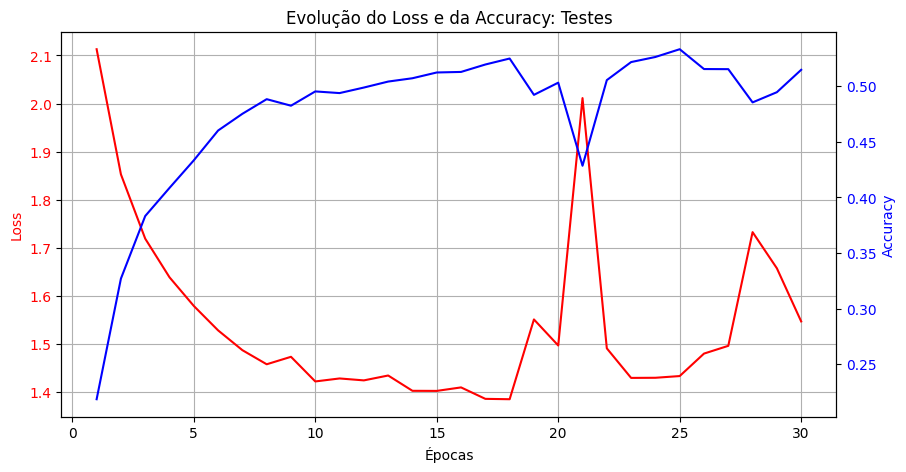

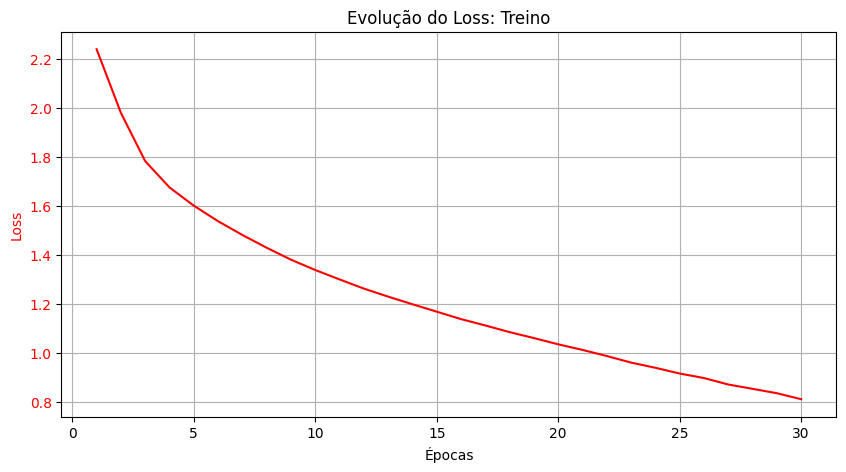

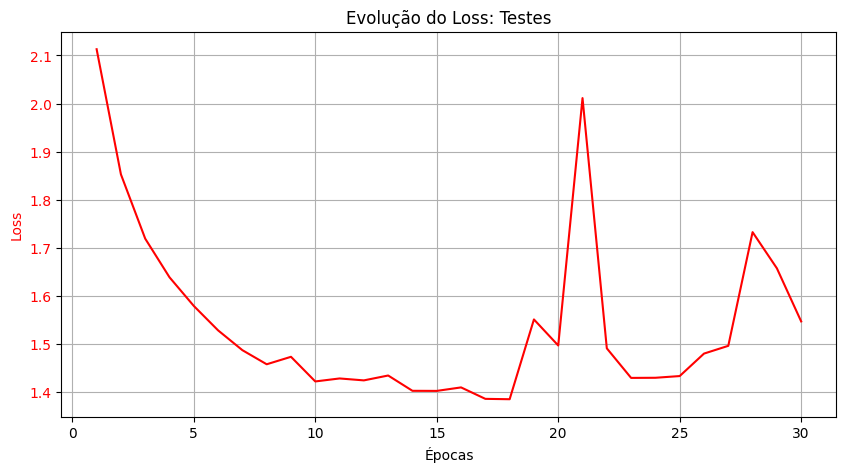

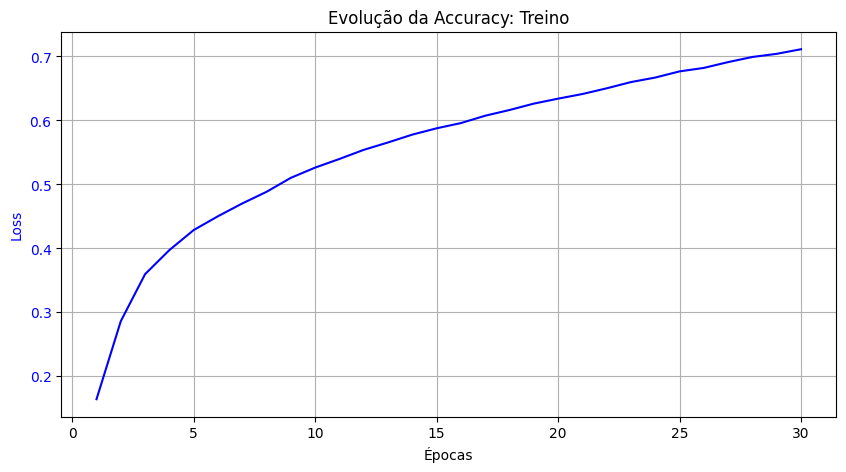

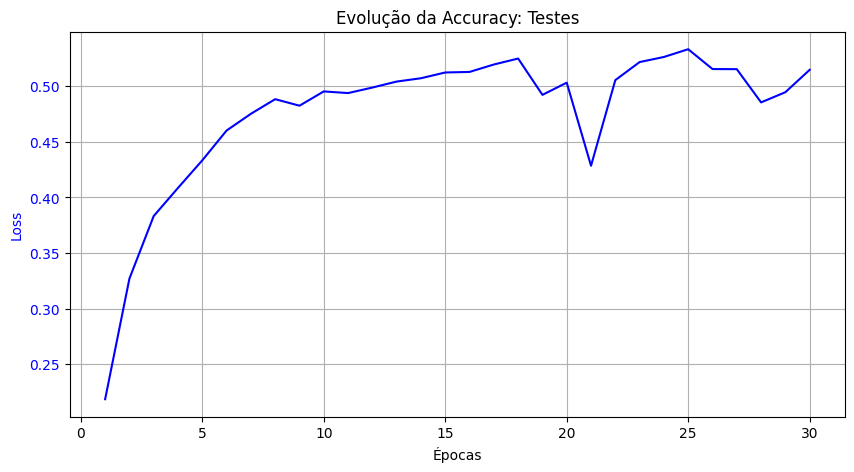

In [12]:
losses_training = [2.2413501128211353, 1.9809364129210372, 1.7838067842261565, 1.6765086002971814, 1.6019657274036456, 1.5384312959583215, 1.482170549500019, 1.4299746119152859, 1.381240280845281, 1.3389825887234925, 1.3005582803045697, 1.2630691708963546, 1.2302589921085425, 1.1990429246059768, 1.168768162693819, 1.13836971900957, 1.1123782633363133, 1.0851626956401883, 1.0608558692133334, 1.035411543782105, 1.0124859492034863, 0.9875071539598352, 0.960687433362312, 0.9394503766313538, 0.9159885092312113, 0.8975238126257191, 0.8710934542633993, 0.8534220441070663, 0.8355130690442937, 0.8109920787460664]
losses_testing = [2.1129089221832857, 1.8529191662551492, 1.7193254528531603, 1.6390337875694225, 1.57952093926205, 1.5287707186048958, 1.4876344932872019, 1.4583468482752515, 1.4738752204141798, 1.4226675542296878, 1.4288796892591342, 1.424878599537406, 1.4350096685871196, 1.4032141391638737, 1.4030238458305408, 1.41028216082579, 1.3864981976284343, 1.3857351541519165, 1.551496167091807, 1.4973773766475118, 2.0113715867328037, 1.4914521164954848, 1.4300162317646536, 1.4302908918660158, 1.4338602875448336, 1.4805379422606937, 1.4966702017055196, 1.7328717556728679, 1.65773968142309, 1.5473658689268075]
accuracies_training = [0.1642623096704483, 0.286245197057724, 0.3598145842552185, 0.3973985016345978, 0.4286884665489197, 0.45028772950172424, 0.4702685475349426, 0.4884910583496094, 0.510330080986023, 0.5263147354125977, 0.5398217439651489, 0.5540880560874939, 0.5656369924545288, 0.5778852105140686, 0.5877357721328735, 0.595927894115448, 0.6074168682098389, 0.6163483262062073, 0.6263187527656555, 0.6340912580490112, 0.6413243412971497, 0.6502557396888733, 0.6600064039230347, 0.6670796275138855, 0.6767103672027588, 0.6821451187133789, 0.6912564039230347, 0.6992686986923218, 0.7041640281677246, 0.7113571166992188]
accuracies_testing = [0.2186504751443863, 0.3270302414894104, 0.3832603394985199, 0.4085390269756317, 0.4333200752735138, 0.46009156107902527, 0.475119411945343, 0.4882563650608063, 0.4823845624923706, 0.49522292613983154, 0.4937300980091095, 0.49870622158050537, 0.5040804147720337, 0.5070660710334778, 0.5122412443161011, 0.512738823890686, 0.5194068551063538, 0.5247810482978821, 0.49213773012161255, 0.503085196018219, 0.42844346165657043, 0.5053741931915283, 0.5215963125228882, 0.5261743664741516, 0.5331408977508545, 0.5153264403343201, 0.5152269005775452, 0.4853702187538147, 0.4945262670516968, 0.5146297812461853]

plot_all_graphs(losses_training, losses_testing, accuracies_training, accuracies_testing)

# Arquitetura 4 (camada extra): Camadas com 3072, 256, 128, 64, 32, 10 neurônios (30 épocas)

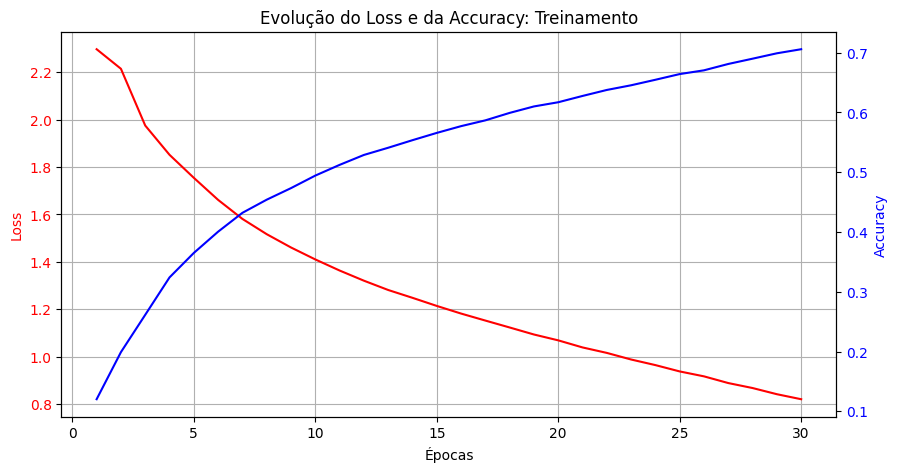

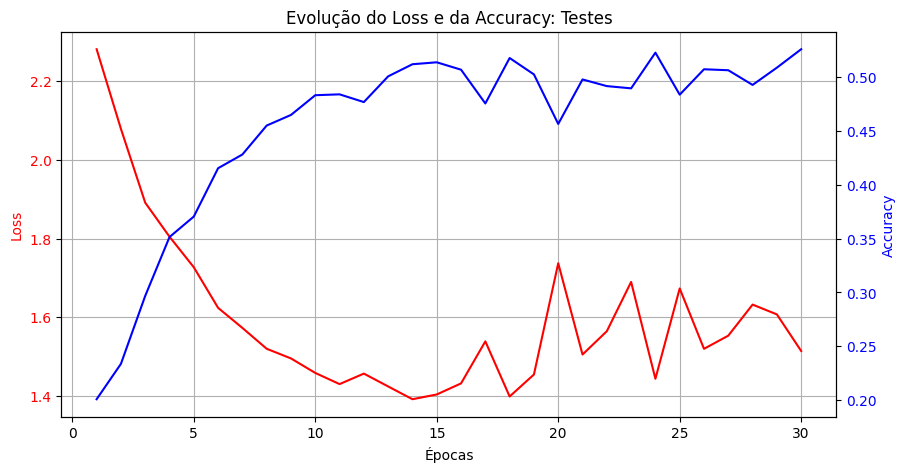

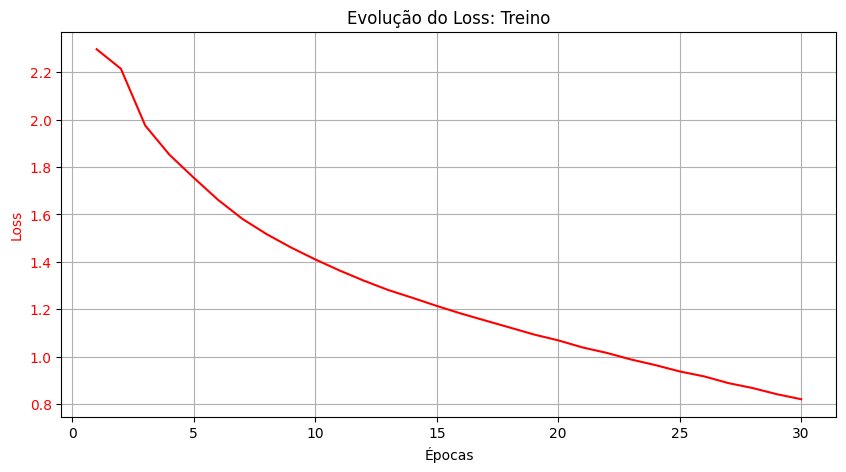

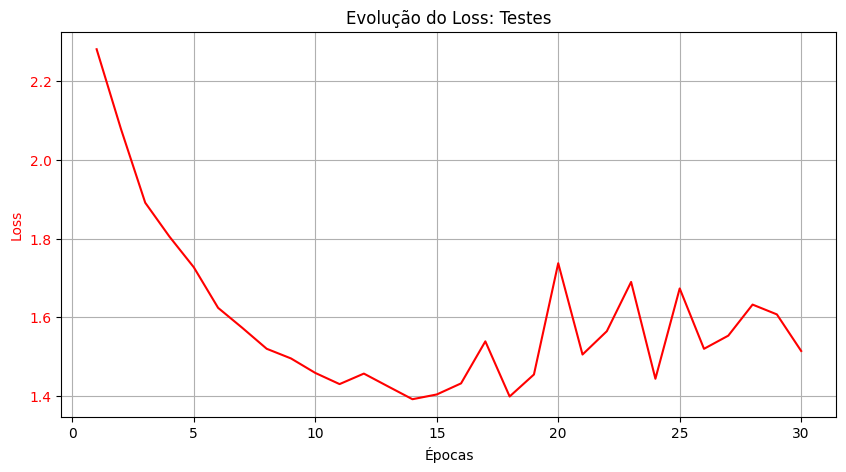

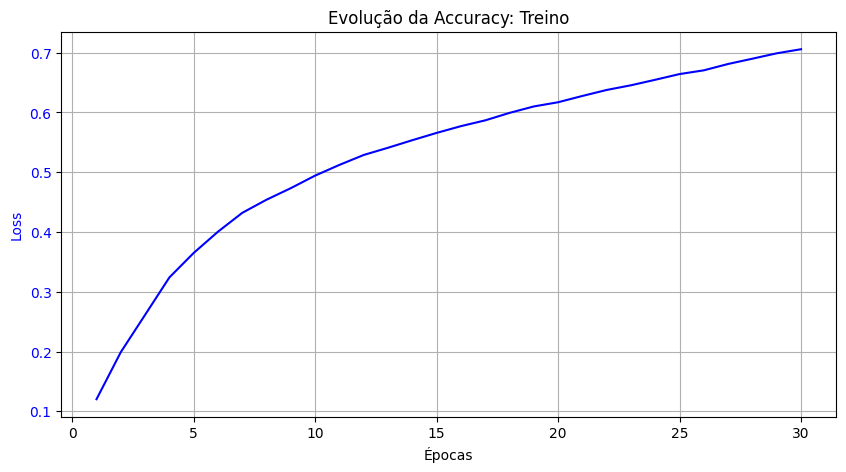

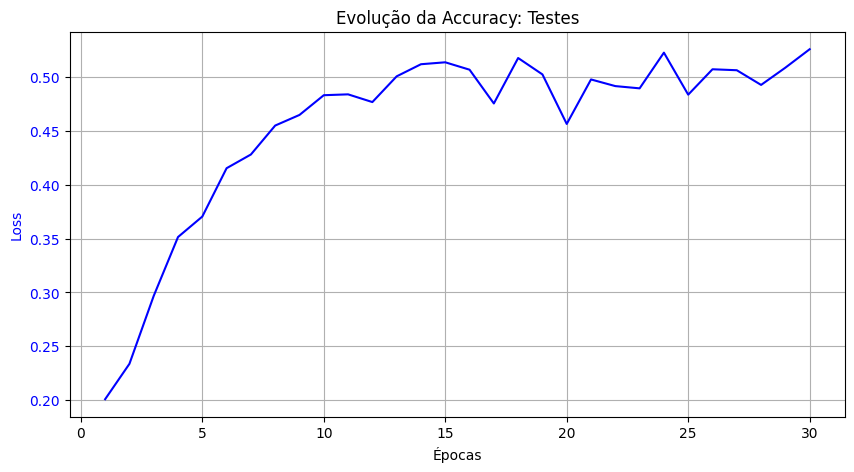

In [13]:
losses_training = [2.2968713426224108, 2.214355806865351, 1.974995674836971, 1.8515279975998433, 1.7544711924269987, 1.6614079826018389, 1.5811474093085969, 1.5167697619294267, 1.4606427800319994, 1.4102328133095257, 1.3634911342654996, 1.3206042621446692, 1.2813241939105646, 1.2483102888097544, 1.2141270850930372, 1.18190611102392, 1.1523672369739892, 1.1231691428767445, 1.0935919553879887, 1.068869633900235, 1.039022805898086, 1.015929179194638, 0.9880898458421078, 0.9644981279702443, 0.9377923546849615, 0.9170136690292212, 0.888722065769498, 0.8677476358688091, 0.8417290135875077, 0.8205741071487631]
losses_testing = [2.281144398792534, 2.0787364555771943, 1.8910821152340835, 1.8046838910716354, 1.7269361505083218, 1.6238321430364233, 1.5728043629105684, 1.5198281904694382, 1.4952589448090572, 1.458435372941813, 1.4300457113867353, 1.4567651528461723, 1.4240242060582349, 1.391613567710682, 1.4036919121529645, 1.431856477336519, 1.5386750728461394, 1.3985672779143996, 1.4544411358559968, 1.7372061424194627, 1.5052093654681162, 1.5644383582339925, 1.6896895504301521, 1.4436027020405813, 1.673123916243292, 1.519715063131539, 1.5531905426341257, 1.6321243191980253, 1.607202780474523, 1.5142206485104408]
accuracies_training = [0.12020460516214371, 0.19896899163722992, 0.26136907935142517, 0.32394900918006897, 0.36486971378326416, 0.40043559670448303, 0.4319852888584137, 0.4539642035961151, 0.4733056128025055, 0.49426549673080444, 0.5121883153915405, 0.5287923812866211, 0.5408408045768738, 0.5535086393356323, 0.5656769275665283, 0.5769860744476318, 0.5866767764091492, 0.5991448163986206, 0.6099544167518616, 0.6169677376747131, 0.6274976134300232, 0.6375280022621155, 0.6453604698181152, 0.6545715928077698, 0.6641024351119995, 0.6703764200210571, 0.6810062527656555, 0.6898377537727356, 0.698849081993103, 0.7056625485420227]
accuracies_testing = [0.20083598792552948, 0.23367834091186523, 0.2967754900455475, 0.35141322016716003, 0.37042197585105896, 0.41530653834342957, 0.428045392036438, 0.454916387796402, 0.4647690951824188, 0.48308122158050537, 0.48387739062309265, 0.47671177983283997, 0.5005971193313599, 0.5118431448936462, 0.5136345624923706, 0.5067675113677979, 0.47541800141334534, 0.5176154375076294, 0.5023885369300842, 0.4564092457294464, 0.4977109730243683, 0.4915406107902527, 0.4894506335258484, 0.5225915312767029, 0.4835788309574127, 0.5071656107902527, 0.5062699317932129, 0.4926353394985199, 0.5086584687232971, 0.5257762670516968]

plot_all_graphs(losses_training, losses_testing, accuracies_training, accuracies_testing)